In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import re

Import de données

In [ ]:
CAC40_txt = """Accor SA (AC.PA)
L'Air Liquide S.A. (AI.PA)
Airbus SE (AIR.PA)
ArcelorMittal S.A. (MT)
AXA SA (CS.PA)
BNP Paribas SA (BNP.PA)
Bouygues SA (EN.PA)
Bureau Veritas SA (BVI.PA)
Capgemini SE (CAP.PA)
Carrefour SA (CA.PA)
Crédit Agricole S.A. (ACA.PA)
Danone S.A. (BN.PA)
Dassault Systèmes SE (DSY.PA)
Edenred SE (EDEN.PA)
Engie SA (ENGI.PA)
EssilorLuxottica Société anonyme (EL.PA)
Eurofins Scientific SE (ERF.PA)
Hermès International (RMS.PA)
Kering SA (KER.PA)
Legrand SA (LR.PA)
L'Oréal S.A. (OR.PA)
LVMH (MC.PA)
Michelin (ML.PA)
Orange S.A. (ORA.PA)
Pernod Ricard SA (RI.PA)
Publicis Groupe S.A. (PUB.PA)
Renault SA (RNO.PA)
Safran SA (SAF.PA)
Compagnie de Saint-Gobain S.A. (SGO.PA)
Sanofi (SAN.PA)
Schneider Electric S.E. (SU.PA)
Société Générale (GLE.PA)
Stellantis N.V. (STLAP.PA)
STMicroelectronics N.V. (STMPA.PA)
Teleperformance SE (TEP.PA)
Thales S.A. (HO.PA)
TotalEnergies SE (TTE.PA)
Unibail-Rodamco-Westfield SE (URW.PA)
Veolia Environnement SA (VIE.PA)
Vinci SA (DG.PA)"""

tickers_CAC40 = re.findall(r'\(([^)]+)\)', CAC40_txt)

In [64]:
histo_CAC40 = yf.download(tickers = tickers_CAC40, start = '2015-01-01',end = '2025-02-01')["Close"]
histo_CAC40_maille1h =  yf.download(tickers = tickers_CAC40, start = '2024-01-01',end = '2025-02-01', interval='1h')["Close"]

[*********************100%***********************]  40 of 40 completed
[*********************100%***********************]  40 of 40 completed

1 Failed download:
['MT.PA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2024-01-01 -> 2025-02-01)')


In [59]:
print(histo_CAC40.shape)
histo_CAC40["TEP.PA"].head(10)

(2606, 40)


Date
2015-01-02    48.126030
2015-01-05    47.900623
2015-01-06    47.124268
2015-01-07    47.216095
2015-01-08    48.142719
2015-01-09    47.666882
2015-01-12    49.920837
2015-01-13    50.104492
2015-01-14    49.879101
2015-01-15    50.588673
Name: TEP.PA, dtype: float64

Data cleaning

In [62]:
nan_par_colonne = {col: histo_CAC40.index[histo_CAC40[col].isna()].tolist() for col in histo_CAC40.columns}
for col in histo_CAC40.columns:
    taille_liste = len(nan_par_colonne[col])
    print(col, len(nan_par_colonne[col])) if taille_liste > 0 else next
    #print(col, len(nan_par_colonne[col]), nan_par_colonne[col]) if taille_liste > 0 else next


AC.PA 23
ACA.PA 23
AI.PA 23
AIR.PA 23
BN.PA 23
BNP.PA 23
BVI.PA 23
CA.PA 23
CAP.PA 23
CS.PA 23
DG.PA 23
DSY.PA 23
EDEN.PA 23
EL.PA 23
EN.PA 23
ENGI.PA 23
ERF.PA 23
GLE.PA 23
HO.PA 23
KER.PA 23
LR.PA 23
MC.PA 23
ML.PA 23
MT 70
OR.PA 23
ORA.PA 23
PUB.PA 23
RI.PA 23
RMS.PA 23
RNO.PA 23
SAF.PA 23
SAN.PA 23
SGO.PA 23
STLAP.PA 23
STMPA.PA 23
SU.PA 23
TEP.PA 23
TTE.PA 23
URW.PA 2145
VIE.PA 23


In [6]:
histo_CAC40_sans_MT_URW = histo_CAC40.drop(columns=["URW.PA", "MT.AS"])
print(int(histo_CAC40_sans_MT_URW.isna().sum().sum()))
print(histo_CAC40_sans_MT_URW.shape)

0
(2583, 38)


Calcul des rendements, volatilités et corrélations

In [ ]:
data = histo_CAC40_sans_MT_URW
# Calcul du vecteur de rendement moyen annuel
mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25

print("Rendements annuels :")
print(mu_annuel.head())

Rendements annuels :
Ticker
AC.PA     0.043649
ACA.PA    0.088683
AI.PA     0.112176
AIR.PA    0.151292
BN.PA     0.052707
dtype: float64


In [8]:
delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

print("\nVolatilités :")
print(Volatilite_annuel.head())


Volatilités :
Ticker
AC.PA     0.319046
ACA.PA    0.309398
AI.PA     0.206439
AIR.PA    0.351945
BN.PA     0.194999
dtype: float64


In [9]:
print("\nMatrice de correlation :")
print(mat_correlation.iloc[ :7, :7])


Matrice de correlation :
Ticker     AC.PA    ACA.PA     AI.PA    AIR.PA     BN.PA    BNP.PA    BVI.PA
Ticker                                                                      
AC.PA   1.000000  0.585502  0.428098  0.634052  0.354309  0.602450  0.451828
ACA.PA  0.585502  1.000000  0.480506  0.558154  0.339130  0.853126  0.470121
AI.PA   0.428098  0.480506  1.000000  0.484547  0.499491  0.499644  0.519341
AIR.PA  0.634052  0.558154  0.484547  1.000000  0.373538  0.591403  0.465813
BN.PA   0.354309  0.339130  0.499491  0.373538  1.000000  0.367019  0.406833
BNP.PA  0.602450  0.853126  0.499644  0.591403  0.367019  1.000000  0.471934
BVI.PA  0.451828  0.470121  0.519341  0.465813  0.406833  0.471934  1.000000


In [10]:
#On travaille à la maille journalière
data = histo_CAC40_sans_MT_URW
log_return_jounalier_histo = np.log(data/data.shift(1))
log_return_jounalier_histo.iloc[0, :] = 0
log_return_jounalier_histo.head()

Ticker,AC.PA,ACA.PA,AI.PA,AIR.PA,BN.PA,BNP.PA,BVI.PA,CA.PA,CAP.PA,CS.PA,...,RNO.PA,SAF.PA,SAN.PA,SGO.PA,STLAP.PA,STMPA.PA,SU.PA,TEP.PA,TTE.PA,VIE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,-0.012959,-0.046957,-0.031456,0.003006,-0.025956,-0.049772,-0.045848,-0.049668,-0.013396,-0.037881,...,-0.035515,-0.001961,-0.029186,-0.044038,0.0,-0.015053,-0.044512,-0.004695,-0.061713,-0.025169
2015-01-06,-0.021146,-0.019418,-0.008380,0.022905,-0.003053,-0.026502,-0.007134,-0.007995,-0.039369,-0.010935,...,-0.005203,0.006846,0.003270,-0.016027,0.0,-0.010821,0.001394,-0.016340,-0.001502,-0.014065
2015-01-07,0.004983,-0.014318,0.004505,0.025714,0.011592,-0.016844,0.002002,-0.001057,0.004199,0.010663,...,-0.002263,0.016625,0.010555,-0.002721,0.0,0.020720,0.006250,0.001947,0.022418,0.007760
2015-01-08,0.019824,0.024074,0.041231,0.033509,0.028496,0.031905,0.024281,0.044461,0.028064,0.040506,...,0.037960,0.029470,0.041269,0.039628,0.0,0.032878,0.040365,0.019435,0.037853,0.018451


In [11]:
nb_stocks = log_return_jounalier_histo.shape[1]
allocations_EW = np.ones(nb_stocks) / nb_stocks

In [20]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
        last_period = (nb_periods//T_rebalancement)*T_rebalancement
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution


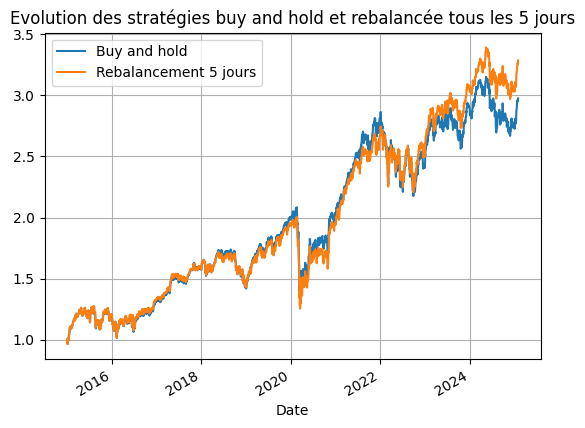

In [80]:
# Exemple d'utilisation
allocation = np.ones(nb_stocks) / nb_stocks
evolution_huyHold = generate_evolution(log_return_jounalier_histo, allocation)
evolution_Rebal = generate_evolution(log_return_jounalier_histo, allocation, T_rebalancement = 5)
evolution_huyHold.sum(axis=1).plot(label="Buy and hold")
evolution_Rebal.sum(axis=1).plot(label="Rebalancement 5 jours")
plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.legend()
plt.grid()
plt.show()

In [53]:
def generate_scenarios(rendement, volatilities, correlationMatrix, nb_scenario, BeginDate, EndDate, seed=1):
    np.random.seed(seed)
    nb_stocks = len(volatilities)
    
    # Génération des dates excluant les samedis et dimanches
    dates = pd.date_range(start=BeginDate, end=EndDate, freq='B')
    nb_periods = len(dates)
    
    # Calcul du facteur d'ajustement pour les volatilities
    delta_t = dates.to_series().diff().dt.days[1:] / 365.25
    delta_t = np.insert(delta_t, 0, 0)  # Insert 0 at the beginning
    adjustment_factor = np.sqrt(delta_t)
    
    # Génération de scénarios de log-rendements
    log_returns = np.random.normal(0, 1, (nb_periods, nb_stocks, nb_scenario))
    cholesky_matrix = np.linalg.cholesky(correlationMatrix)
    
    for i in range(nb_scenario):
        log_returns[:, :, i] = log_returns[:, :, i] @ cholesky_matrix.T
    
    log_returns = log_returns * (volatilities.values[:, None] * adjustment_factor[:, None, None])
    
    # Ajout du rendement moyen annuel
    mean_returns = (rendement.values[:, None] / 256.2305133079848) * delta_t[:, None, None]
    log_returns += mean_returns
    
    # Création du dictionnaire de DataFrames
    scenarios = {f'Scenario {i+1}': pd.DataFrame(log_returns[:, :, i], index=dates, columns=volatilities.index) for i in range(nb_scenario)}
    
    return scenarios

In [78]:
# Définir les dates de début et de fin
BeginDate = '2025-02-27'
EndDate = '2035-03-01'

# Générer les scénarios
scenarios = generate_scenarios(mu_annuel, Volatilite_annuel, mat_correlation, nb_scenario=100, BeginDate=BeginDate, EndDate=EndDate, seed=250)

# Afficher les premiers scénarios pour vérifier
for scenario_name, scenario_data in scenarios.items():
    print(f"{scenario_name}:\n", scenario_data.head(), "\n")

Scenario 1:
 Ticker         AC.PA    ACA.PA     AI.PA    AIR.PA     BN.PA    BNP.PA  \
2025-02-27  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2025-02-28  0.019750  0.011554 -0.003764 -0.003933  0.001357  0.016106   
2025-03-03 -0.009417 -0.006786 -0.026724 -0.029434 -0.008671 -0.008761   
2025-03-04 -0.002995  0.007167  0.013968  0.012089  0.007430  0.020122   
2025-03-05  0.003253  0.013542 -0.004661  0.005648 -0.005714  0.007558   

Ticker        BVI.PA     CA.PA    CAP.PA     CS.PA  ...    RNO.PA    SAF.PA  \
2025-02-27  0.000000 -0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2025-02-28  0.005336  0.008652  0.002384  0.020567  ...  0.021579 -0.003060   
2025-03-03 -0.013489 -0.014571 -0.019377 -0.019597  ... -0.012224 -0.057195   
2025-03-04  0.008409  0.003719 -0.001583  0.014950  ...  0.012250  0.021399   
2025-03-05  0.008568 -0.009142 -0.009274  0.019165  ...  0.005084  0.004866   

Ticker        SAN.PA    SGO.PA  STLAP.PA  STMPA.PA     SU.PA    TEP

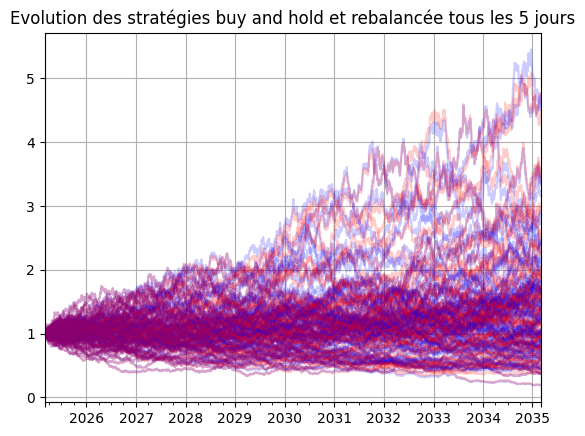

In [79]:
# Exemple d'utilisation
allocation = np.ones(nb_stocks) / nb_stocks
i=0

for scenario_name, scenario_data in scenarios.items():
    evolution_huyHold_sce1 = generate_evolution(scenario_data, allocation)
    evolution_Rebal_sce1 = generate_evolution(scenario_data, allocation, T_rebalancement = 20)
    evolution_huyHold_sce1.sum(axis=1).plot(color="blue", alpha=0.2)
    evolution_Rebal_sce1.sum(axis=1).plot(color="red", alpha=0.2)
    i+=1
plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
#plt.legend()
plt.grid()
plt.show()